In [37]:
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np

2.1 Loading the MNIST dataset

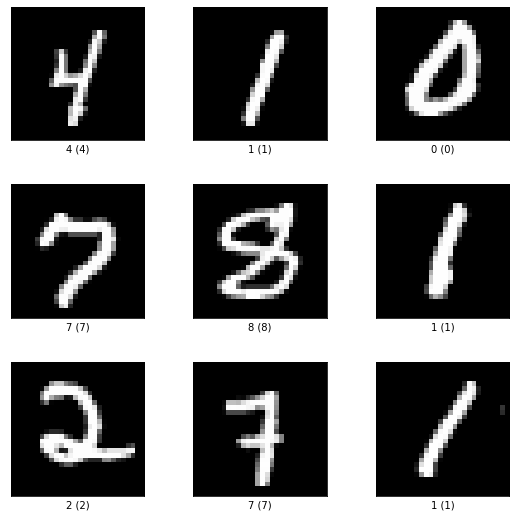

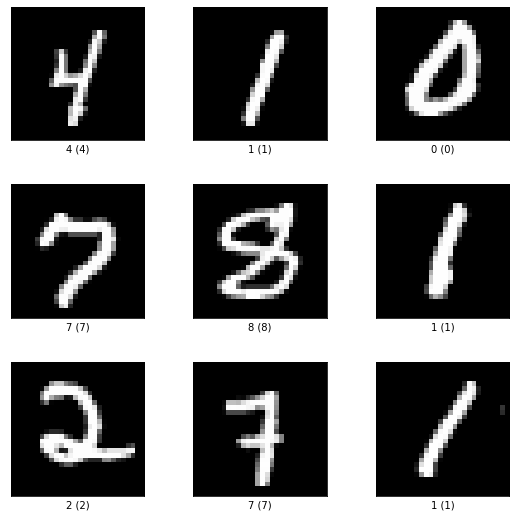

In [38]:
(train_ds, test_ds), ds_info = tfds.load(
    'mnist', split=['train', 'test'],
    as_supervised=True, with_info=True)
tfds.show_examples(train_ds, ds_info)


mnist dataset: database of handwritten digits
- 70,000 images: 60k train, 10k test
- image shape: (28,28,1) -> 784 Pixel(?), black & white
- Pixel values: 0-255




2.2 Setting up the data pipeline

In [39]:
def prepare_mnist_data(mnist):
    #flatten the images into vectors
    mnist = mnist.map(lambda img, target: (tf.reshape(img, (-1,)), target))
    #convert data from uint8 to float32
    mnist = mnist.map(lambda img, target: (tf.cast(img, tf.float32), target))
    #sloppy input normalization, just bringing image values from range [0, 255] to [-1, 1]
    mnist = mnist.map(lambda img, target: ((img/128.)-1., target))
    #create one-hot targets
    mnist = mnist.map(lambda img, target: (img, tf.one_hot(target, depth=10)))
    #cache this progress in memory, as there is no need to redo it; it is deterministic after all
    mnist = mnist.cache()
    #shuffle, batch, prefetch
    mnist = mnist.shuffle(1000)
    mnist = mnist.batch(32)
    mnist = mnist.prefetch(20)
    #return preprocessed dataset
    return mnist

train_dataset = train_ds.apply(prepare_mnist_data)
test_dataset = test_ds.apply(prepare_mnist_data)

2.3 Building a deep neural network with TensorFlow

In [40]:
class Model(tf.keras.Model):
    
    def __init__(self):
        #initialize with super class
        super(Model, self).__init__()

        # 2 hidden layers & one output layer
        self.dense1 = tf.keras.layers.Dense(256, activation=tf.nn.relu)
        self.dense2 = tf.keras.layers.Dense(256, activation=tf.nn.relu)
        self.out = tf.keras.layers.Dense(10, activation=tf.nn.softmax)

    @tf.function
    def call(self, inputs):
        #pass signal through layers of the NN
        x = self.dense1(inputs)
        x = self.dense2(x)
        x = self.out(x)
        return x
    

In [41]:
# functionality for training and testing for the training loop

def train_step(model, input, target, loss_function, optimizer):
    # loss_object and optimizer_object are instances of respective tensorflow classes 
    with tf.GradientTape() as tape:
        #forward step
        prediction = model(input)
        #calculate loss
        loss = loss_function(target, prediction)
    #update variables
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

def test(model, test_data, loss_function):
    # test over complete test data
    
    #record accuracy and loss in list
    test_accuracy_aggregator = []
    test_loss_aggregator = []

    for (input, target) in test_data:
        #perform forward step
        prediction = model(input)
        #calculate loss and accuracy
        sample_test_loss = loss_function(target, prediction)
        sample_test_accuracy =  np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
        sample_test_accuracy = np.mean(sample_test_accuracy)
        #append accuracy and loss to list
        test_loss_aggregator.append(sample_test_loss.numpy())
        test_accuracy_aggregator.append(np.mean(sample_test_accuracy))
    
    #calculate mean of loss and accuracy to return
    test_loss = tf.reduce_mean(test_loss_aggregator)
    test_accuracy = tf.reduce_mean(test_accuracy_aggregator)

    return test_loss, test_accuracy 

2.4 Training the network

In [ ]:

def training_loop(num_epochs, model, train_ds, test_ds, cross_entropy_loss, optimizer, lists):
    # unpack the lists for tracking loss and accuracy
    train_losses, test_losses, test_accuracies = lists[0], lists[1], lists[2]

    # We train for num_epochs epochs.
    for epoch in range(num_epochs):
        print(f'Epoch: {str(epoch)} starting with accuracy {test_accuracies[-1]}')

        #training (and checking in with training)
        epoch_loss_agg = []
        for input,target in train_dataset:
            train_loss = train_step(model, input, target, cross_entropy_loss, optimizer)
            epoch_loss_agg.append(train_loss)

        #track training loss
        train_losses.append(tf.reduce_mean(epoch_loss_agg))

        #testing, so we can track accuracy and test loss
        test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

    # return lists for tracking the loss and accurcy
    return [train_losses, test_losses, test_accuracies]

In [42]:
tf.keras.backend.clear_session()

### Hyperparameters
num_epochs = 10
learning_rate = 0.001
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate)

# Initialize the model
model = Model()

In [44]:
# Initialize lists for later visualization.
train_losses = []
test_losses = []
test_accuracies = []

#testing once before we begin
test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

#check how model performs on train data once before we begin
train_loss, _ = test(model, train_dataset, cross_entropy_loss)
train_losses.append(train_loss)

# training loop
lists = training_loop(num_epochs, model, train_ds, test_ds, cross_entropy_loss, optimizer, [train_losses, test_losses, test_accuracies])

# unpack the returned lists for tracking the loss and accuracy
train_losses = lists[0]
test_losses = lists[1]
test_accuracies = lists[2]

Epoch: 0 starting with accuracy 0.09315095846645367
Epoch: 1 starting with accuracy 0.950479233226837
Epoch: 2 starting with accuracy 0.9597643769968051
Epoch: 3 starting with accuracy 0.9642571884984026
Epoch: 4 starting with accuracy 0.9690495207667732
Epoch: 5 starting with accuracy 0.9746405750798722
Epoch: 6 starting with accuracy 0.9714456869009584
Epoch: 7 starting with accuracy 0.9689496805111821
Epoch: 8 starting with accuracy 0.9714456869009584
Epoch: 9 starting with accuracy 0.9674520766773163


2.5 Visualization

tf.Tensor(0.04660874, shape=(), dtype=float32)
tf.Tensor(0.11598203, shape=(), dtype=float32)
tf.Tensor(0.9756389776357828, shape=(), dtype=float64)


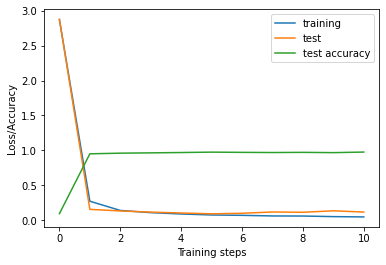

In [45]:
import matplotlib.pyplot as plt

# print the final loss and accuracy for testing different hyperparameters
print(test_losses[-1])
print(test_accuracies[-1])

# Visualize accuracy and loss for training and test data.
plt.figure()
line1, = plt.plot(train_losses)
line2, = plt.plot(test_losses)
line3, = plt.plot(test_accuracies)
plt.xlabel("Training steps")
plt.ylabel("Loss/Accuracy")
plt.legend((line1,line2, line3),("training","test", "test accuracy"))
plt.show()

3 Adjusting the hyperparameters of your model

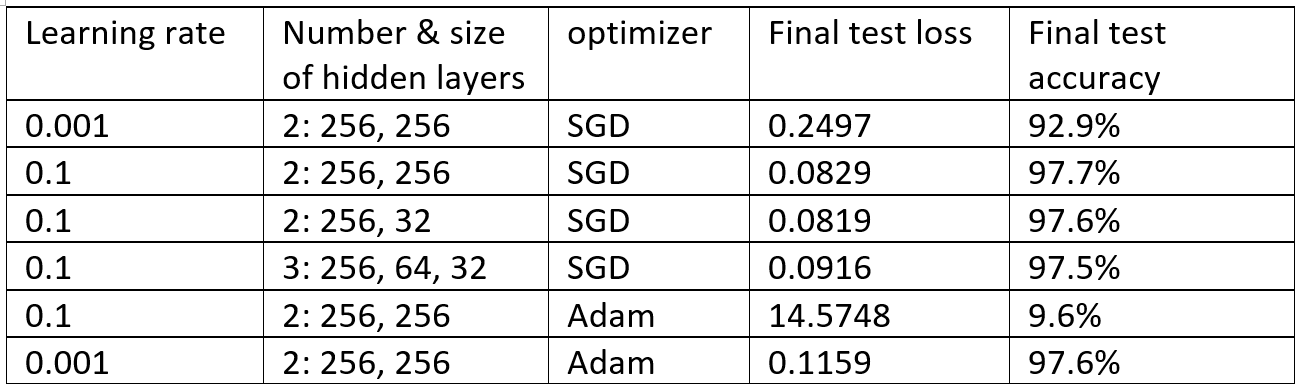

Conclusion

Out of the combinations we tested, for the SGD optimizer the best accuracy and smallest test loss was received with two hiddenlayers and a learning rate of 0.1. We tested the same NN-structure and learning rate with the ADAM optimizer and received a much higher loss and much smaller accuracy. For the ADAM optimizer a small learning rate was better suited.